# Graph Policy Network for Maximum Independent Set
Authors: Mai Pham, Alexander Huang-Menders, Jackson Yassin, Benjamin Grayzel

Dataset: Facebook Social Circle (SNAP).
We only work on the (unweighted) edge data.

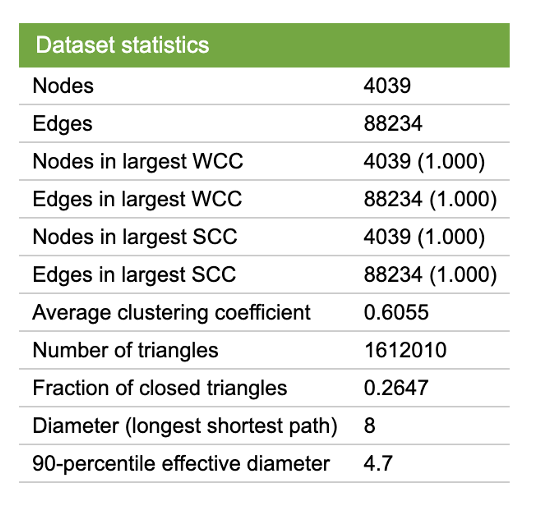

## Pre-processing

In [ ]:
!pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu121
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.1+cu121.html
!pip install torch-geometric


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import random
import os
if not os.path.isdir("data"):
    os.mkdir("data")

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
def extract_tarfile(source_path, destination_path):
    import tarfile
    f = tarfile.open(source_path)
    f.extractall(destination_path)
    f.close()

def read_file(file_path):
    with open(file_path) as f :
        content = f.readlines()
        content = [line.replace("\n","") for line in content]
        content = [line.split("\t") for line in content]
    if file_path.endswith('.circles'):
        return {circle[0]:list(map(int,circle[1:])) for circle in content}
    elif file_path.endswith('.edges'):
        return [list(map(int, group[0].split())) for group in content]

def read_txt_gz(path):
    import gzip
    edges = []
    with gzip.open(path, 'rt') as file:
        for line in file:
            node1, node2 = map(int, line.strip().split())
            edges.append((node1, node2))
    return edges

class SocialCirclesGraph:
    def __init__(self, edges):
        self.G = nx.Graph()
        max_nodes = max([max(e) for e in edges]) + 1
        self.G.add_nodes_from(range(max_nodes))
        self.G.add_edges_from(edges)
        self.adjacency_matrix = nx.to_numpy_array(self.G)
        self.num_nodes = len(self.G.nodes())
        self.num_edges = len(self.G.edges())
        self.degree = self.G.degree()
        self.edge_index = torch.tensor(edges, dtype=torch.long).T

def plot_degree_distribution(graph, title):
    degrees = [degree for _, degree in graph.degree()]
    plt.hist(degrees, bins=range(1, max(degrees) + 2, 20), edgecolor="black", alpha=0.5)
    plt.title(title)
    plt.xlabel("Degrees")
    plt.ylabel("Frequency")
    plt.show()

def plot_degree_distribution(graph, title):
    degrees = np.array([degree for _, degree in graph.degree()])  # Create a NumPy array from the degree list

    # Count the frequencies of degrees using numpy
    degree_count = np.bincount(degrees)

    # Set up the figure and axes for two plots side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the degree distribution
    ax[0].bar(range(1, max(degrees)+2), degree_count, edgecolor="black")
    ax[0].hist(degrees, bins=range(1, max(degrees) + 2, 10), edgecolor="black", alpha=0.5)
    ax[0].set_title("Degree Distribution", size=18)
    ax[0].set_xlabel("Degree", size=14)
    ax[0].set_ylabel("Frequency", size=14)
    ax[0].grid(True)
    ax[0].set_ylim(0, 1000)

    # Prepare data for the log-log plot
    degrees_for_log_plot = np.arange(len(degree_count))
    log_degrees = np.log(degrees_for_log_plot[degree_count > 0])  # Get log of degree indices where counts > 0
    log_counts = np.log(degree_count[degree_count > 0])  # Get log of counts where counts > 0

    # Plot the log-log degree distribution
    ax[1].scatter(log_degrees, log_counts, color='blue', alpha=0.5)
    ax[1].set_title("Log-Log Degree Distribution", size=18)
    ax[1].set_xlabel("Log (Degree)", size=14)
    ax[1].set_ylabel("Log (Frequency)", size=14)
    ax[1].grid(True)

    plt.tight_layout()  # Adjust layout so plots do not overlap
    plt.show()

# sort degrees then select k highest/lowest degree
def get_dense_sparse_graphs(G, edge_index, top_high=2, num_hop_high=1, top_low=5, num_hop_low=4):
    from torch_geometric.utils import k_hop_subgraph # avoid env conflict

    degree_sequence = sorted(G.degree(), key=lambda x: x[1], reverse=True)
    high_degree_nodes = [node for node, _ in degree_sequence[:top_high]]
    low_degree_nodes = [node for node, _ in degree_sequence[-top_low:]]
    dense_nodes, dense_edges, _, _ = k_hop_subgraph(
        node_idx=high_degree_nodes, num_hops=num_hop_high, edge_index=edge_index, relabel_nodes=True)
    sparse_nodes, sparse_edges, _, _ = k_hop_subgraph(
        node_idx=low_degree_nodes, num_hops=num_hop_low, edge_index=edge_index, relabel_nodes=True)

    # Convert the dense and sparse edge lists back to NetworkX graphs
    dense_graph = nx.Graph()
    dense_graph.add_edges_from(dense_edges.T.tolist())
    print(f"Creating dense graph with {len(dense_nodes)} nodes")

    sparse_graph = nx.Graph()
    sparse_graph.add_edges_from(sparse_edges.T.tolist())
    print(f"Creating sparse graph with {len(sparse_nodes)} nodes")

    return dense_graph, sparse_graph

number of nodes:  4039
number of edges:  88234


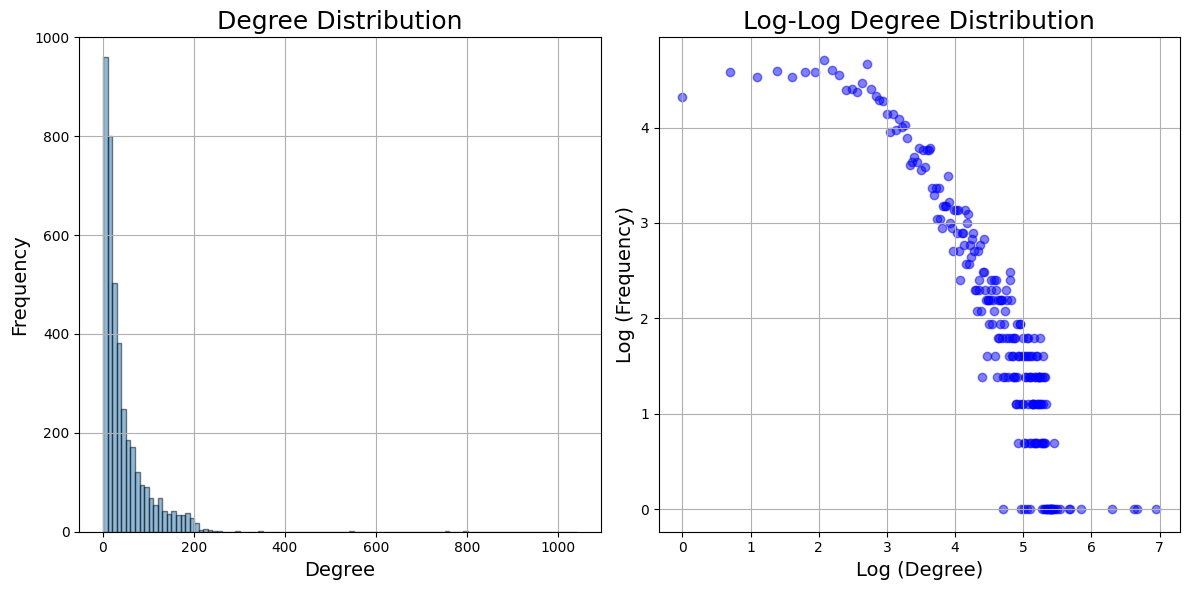

In [ ]:
# Read the entire graph
edge_list = read_txt_gz('/content/drive/MyDrive/COSC89/social-circle/facebook_combined.txt.gz')

combined_graph = SocialCirclesGraph(edge_list)
print("number of nodes: ", combined_graph.num_nodes) # 4039
print("number of edges: ", combined_graph.num_edges) # 88234

plot_degree_distribution(combined_graph.G, "Facebook Social Circles")


In [ ]:
import os
def read_edges_from_txt_files(data_folder):
    edges_list = []  # List to store edges from all files
    for filename in sorted(os.listdir(data_folder)):
        if filename.endswith(".txt"):  # Check for .txt files
            file_path = os.path.join(data_folder, filename)
            with open(file_path, 'r') as file:
                edges = []
                for line in file:
                    line = line.strip()
                    if line:  # Check if the line is not empty
                        try:
                            edge = tuple(map(int, line.split()))
                            edges.append(edge)
                        except ValueError:
                            print(f"Skipping invalid line in {filename}: {line}")
                if edges:  # Only add non-empty edge lists
                    edges_list.append(edges)  # Append edges from this file
    return edges_list

# If accessing graphs from Colab:
# graphs = read_edges_from_txt_files('/content/drive/MyDrive/COSC89/data')
# graphs = {i: SocialCirclesGraph(graphs[i]).G for i in range (len(graphs))}

## Benchmark 1 + 2: Physics-based GNN + Annealing

In [ ]:
!pip install -q git+https://github.com/IvanIsCoding/GNN-for-Combinatorial-Optimization.git

In [ ]:
from gnn_for_co.train import inner_solve_with_gnn, solve_with_annealing

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import trange, tqdm

sns.set_theme()

def solve_with_gnn_mis(
    G,
    embedding_size,
    hidden_size,
    learning_rate,
    epochs,
    epochs_guess,
    dropout_rate,
    seed=2023,
    verbose=False,
    shots=5,
    is_max_cut=True,
):
    lower_bound = -G.number_of_nodes() / 10.0

    for k in range(shots):
        solution = inner_solve_with_gnn(
            G,
            embedding_size,
            hidden_size,
            learning_rate,
            epochs_guess,
            dropout_rate,
            seed + (k + 1) ** 3,
            verbose,
            is_max_cut,
        )

        if solution["energy"] <= -1:
            solution = inner_solve_with_gnn(
                G,
                embedding_size,
                hidden_size,
                learning_rate,
                epochs,
                dropout_rate,
                seed + (k + 1) ** 3,
                verbose,
                is_max_cut,
            )
            break

    return solution

df = pd.DataFrame(columns=["N", "MIS size", "Algorithm"])
gnn_results = []
sa_results = []

for i, G in tqdm(graphs.items()):
    annealing_sol = solve_with_annealing(G, num_reads=1000, is_max_cut=False)
    model = annealing_sol["model"]
    sa_results.append(-annealing_sol["energy"])

    print(f"N = {G.number_of_nodes()}, Anneling found {sa_results[-1]}")

    embedding_d0 = int(np.sqrt(G.number_of_nodes()))
    embedding_d1 = embedding_d0 // 2
    learning_rate = 0.005
    epochs = 25000
    epochs_guess = 100
    dropout_rate = 0.05
    gnn_sol = solve_with_gnn_mis(
        G,
        embedding_d0,
        embedding_d1,
        learning_rate,
        epochs,
        epochs_guess,
        dropout_rate,
        seed=2023,
        verbose=False,
        is_max_cut=False,
        shots=500,
    )

    gnn_results.append(
        -model.decode_sample(gnn_sol["solution"], vartype="BINARY").energy
    )
    print(f"N = {G.number_of_nodes()}, Graph Neural Networks found {gnn_results[-1]}")

## Benchmark 3: Greedy

In [ ]:
def greedy_maximum_independent_set(graph):
    independent_set = set()

    G = graph.copy()

    while G.number_of_nodes() > 0:
        min_degree_node = min(G.nodes(), key=lambda node: G.degree(node))

        independent_set.add(min_degree_node)

        neighbors = set(G.neighbors(min_degree_node))
        for neighbor in neighbors:
            G.remove_node(neighbor)
        G.remove_node(min_degree_node)

    return independent_set

for i, G in tqdm(graphs.items()):
    print(f"N = {G.number_of_nodes()}, Greedy found", len(greedy_maximum_independent_set(G)))

## Benchmark 4: Dynamic Programming

In [ ]:
# Lots of dependency issues with Colab! This model was programmed to run locally
# from the command line which is not supported here. Running locally saves a lot
# of headaches.

# Original Paper repository:
# https://github.com/LIONS-EPFL/dynamic-MIS

# NO LONGER UP TO DATE
# To replicate results, access relevant files here:
# https://github.com/JacksonYassin/GPNtest/tree/DP/MIS_DP

# Update 1/10/25
# Previous link is dead, use this one:
# https://github.com/JacksonYassin/GraphPolicyNetworkforMIS/tree/main/MIS_DP

## Graph Policy Network

In [ ]:
config_0 = {"data": 0, "input_size": 1, "hidden_size": 128, "lr": 1e-3, "num_episodes": 1001, "gamma": 0.5, "max_nodes": 200}
config_107 = {"data": 107, "input_size": 1, "hidden_size": 128, "lr": 1e-3, "num_episodes": 1001, "gamma": 0.5, "max_nodes": 10}
config_1 = {"data": 107, "input_size": 1, "hidden_size": 128, "lr": 1e-3, "num_episodes": 1001, "gamma": 0.5, "max_nodes": 260}
config_2 = {"data": 107, "input_size": 1, "hidden_size": 128, "lr": 1e-3, "num_episodes": 1001, "gamma": 0.5, "max_nodes": 260}

In [ ]:
!pip install -q torch-geometric # this must NOT be installed on the same env as jax

from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, from_networkx


# Load Data
graphs = read_edges_from_txt_files('/content/drive/MyDrive/COSC89/dense_sparse_graph')
graphs = {i: SocialCirclesGraph(graphs[i]).G for i in range (len(graphs))}

In [ ]:
dense_graph, sparse_graph = get_dense_sparse_graphs(
    combined_graph.G, edge_index=combined_graph.edge_index, top_high=425, num_hop_high=1, top_low=1000, num_hop_low=1)

In [ ]:
# Split the state space, keep the action space, can solve problems up to ~500 nodes
# Limited by computational complexity
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data
import torch.nn as nn

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GCNPolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GCNPolicyNetwork, self).__init__()
        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return self.softmax(x)

class GATPolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_heads=1):
        super(GATPolicyNetwork, self).__init__()
        self.gat1 = GATConv(input_size, hidden_size, heads=num_heads, concat=True)
        self.gat2 = GATConv(hidden_size * num_heads, hidden_size, heads=num_heads, concat=True)
        self.fc = nn.Linear(hidden_size * num_heads, output_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        x = self.fc(x)
        return self.softmax(x)

class IterativeMISEnv:
    def __init__(self, adjacency_matrix):
        self.original_graph = adjacency_matrix
        self.num_nodes = len(adjacency_matrix)
        self.reset()

    def reset(self):
        self.graph = np.copy(self.original_graph)
        self.selected_nodes = set()
        self.remaining_nodes = set(range(self.num_nodes))
        return self.get_state()

    def get_state(self):
        state = np.zeros(self.num_nodes)
        state[list(self.selected_nodes)] = 1
        return state

    def get_subgraph(self, max_nodes=10):
        # Select a subset of nodes and their neighbors to create a subgraph
        sub_nodes = list(self.remaining_nodes)[:max_nodes]
        subgraph = self.graph[np.ix_(sub_nodes, sub_nodes)]
        return sub_nodes, subgraph

    def step(self, action, sub_nodes):
        chosen_node = sub_nodes[action]

        feasible = all(self.original_graph[chosen_node][n] == 0 for n in self.selected_nodes)

        if chosen_node in self.remaining_nodes and feasible:
            self.selected_nodes.add(chosen_node)
            neighbors = np.where(self.original_graph[chosen_node] == 1)[0]
            self.remaining_nodes -= set(neighbors)
            self.remaining_nodes.remove(chosen_node)

            reward = 1  # Reward for valid selection
        else:
            reward = -1e3  # Penalize for invalid selection. This won't occur since we remove all neighbors from remainind nodes

        done = len(self.remaining_nodes) == 0
        return self.get_state(), reward, done


# Function to sample an action based on policy
def select_action(policy_net, state, sub_nodes, data):
    x = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(1)  # Node features
    probabilities = policy_net(x, data.edge_index).squeeze()[0][sub_nodes]
    action = torch.multinomial(probabilities, 1).item()
    return action, probabilities

# Iterative Policy Gradient Algorithm with Discounted Rewards
def iterative_policy_gradient(env, policy_net, optimizer, num_episodes=1000, gamma=0.99, max_nodes=50):
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        rewards = []
        log_probs = []
        done = False

        while not done:
            # Obtain subgraph
            sub_nodes, subgraph = env.get_subgraph(max_nodes)
            if len(sub_nodes) == 0:
                break
            edge_index = torch.tensor(np.array(np.nonzero(subgraph)), dtype=torch.long, device=device)
            data = Data(edge_index=edge_index)

            action, probabilities = select_action(policy_net, state, sub_nodes, data)
            next_state, reward, done = env.step(action, sub_nodes)

            rewards.append(reward)
            log_prob = torch.log(probabilities[action] + 1e-8)
            log_probs.append(log_prob)

            total_reward += reward
            state = next_state

        discounted_rewards = []
        cumulative_reward = 0
        for r in reversed(rewards):
            cumulative_reward = r + gamma * cumulative_reward
            discounted_rewards.insert(0, cumulative_reward)

        discounted_rewards = torch.tensor(discounted_rewards)
        loss = []
        for log_prob, reward in zip(log_probs, discounted_rewards):
            loss.append(-log_prob * reward)  # Policy gradient objective
        optimizer.zero_grad()
        loss = torch.stack(loss).sum()
        loss.backward()
        optimizer.step()


        if episode % 100 == 0:
            print(f"Episode {episode}, total reward: {total_reward}, selected nodes: {len(env.selected_nodes)}")

def run_train(config, data=None):
    if data is None:
        data = graphs[config["data"]]

    adjacency_matrix = nx.to_numpy_array(data)

    env = IterativeMISEnv(adjacency_matrix)

    input_size = config["input_size"]
    hidden_size = config["hidden_size"]
    output_size = env.num_nodes
    policy_net = GCNPolicyNetwork(input_size, hidden_size, output_size).to(device)
    optimizer = optim.Adam(policy_net.parameters(), lr=config["lr"]) #8e-4

    iterative_policy_gradient(env, policy_net, optimizer, num_episodes=config["num_episodes"], gamma=config["gamma"], max_nodes=config["max_nodes"])

    return policy_net

from tqdm.notebook import trange, tqdm

config = config_2
for i, G in tqdm(graphs.items()):
    if i in [0]:
        print(i)
        model = run_train(config, data=G)


In [ ]:
# out-of-sample

def run_train(config, graphs):
    # for idx, g in graphs.items():
    for idx, graph in enumerate(graphs):
        print("graph #", idx)
        adjacency_matrix = nx.to_numpy_array(graph)

        env = IterativeMISEnv(adjacency_matrix)

        input_size = config["input_size"]
        hidden_size = config["hidden_size"]
        output_size = env.num_nodes
        policy_net = GCNPolicyNetwork(input_size, hidden_size, output_size).to(device)
        optimizer = optim.Adam(policy_net.parameters(), lr=config["lr"]) #8e-4

        iterative_policy_gradient(env, policy_net, optimizer, num_episodes=config["num_episodes"], gamma=config["gamma"], max_nodes=config["max_nodes"])

    return policy_net

combined_graphs = read_edges_from_txt_files('/content/drive/MyDrive/COSC89/combined_graph_split')
combined_graphs = {i: SocialCirclesGraph(combined_graphs[i]).G for i in range (len(combined_graphs))}

dense_sparse_graphs = read_edges_from_txt_files('/content/drive/MyDrive/COSC89/dense_sparse_graph')
dense_sparse_graphs = {i: SocialCirclesGraph(dense_sparse_graphs[i]).G for i in range (len(dense_sparse_graphs))}

config_3 = {"input_size": 1, "hidden_size": 128, "lr": 1e-3, "num_episodes": 1000, "gamma": 0.5, "max_nodes": 260}
train_graphs = [combined_graphs[i] for i in [0,1,2,3,4,5,6,7]] + [dense_sparse_graphs[j] for j in [0,1,3,4]]
model = run_train(config_3, train_graphs)


In [ ]:
def run_eval(config, policy_net, graphs):
    policy_net.eval()  # Set the policy network to evaluation mode
    total_rewards = []
    total_selected_nodes = []

    with torch.no_grad():  # Disable gradient tracking for evaluation
        for idx, graph in enumerate(graphs):
            adjacency_matrix = nx.to_numpy_array(graph)
            env = IterativeMISEnv(adjacency_matrix)
            state = env.reset()
            done = False
            total_reward = 0

            while not done:
                # Obtain subgraph
                sub_nodes, subgraph = env.get_subgraph(config["max_nodes"])
                if len(sub_nodes) == 0:
                    break

                edge_index = torch.tensor(np.array(np.nonzero(subgraph)), dtype=torch.long, device=device)
                data = Data(edge_index=edge_index)

                # Select action based on the policy
                action, _ = select_action(policy_net, state, sub_nodes, data)

                # Perform the action
                next_state, reward, done = env.step(action, sub_nodes)

                # Accumulate reward and update state
                total_reward += reward
                state = next_state

            total_rewards.append(total_reward)
            total_selected_nodes.append(len(env.selected_nodes))

            print(f"Graph {idx + 1}: Total Reward: {total_reward}, Selected Nodes: {len(env.selected_nodes)}")

    avg_reward = np.mean(total_rewards)
    avg_selected_nodes = np.mean(total_selected_nodes)

    print(f"Average Reward on Unseen Graphs: {avg_reward}")
    print(f"Average Selected Nodes on Unseen Graphs: {avg_selected_nodes}")

    return avg_reward, avg_selected_nodes

test_graphs = [graphs[i] for i in [2]]
run_eval(config, model, test_graphs)